In [1]:
import ipywidgets as widgets
import numpy as np
from ase.cluster import Decahedron
from traitlets import link

from abtem import PixelatedDetector, SMatrix, GridScan, Potential, show_atoms, FrozenPhonons
from abtem.visualize.interactive.artists import MeasurementArtist2d
from abtem.visualize.interactive.canvas import Canvas
from abtem.visualize.interactive.tools import BoxZoomTool, PanZoomTool, SelectPixelTool, BoxSelectPixelTool

# 4D-STEM data visualization

In [2]:
p = 4
q = 2
r = 1

atoms = Decahedron('Au', p, q, r, latticeconstant=None)
atoms.rotate(30, 'x', center='cop')

atoms.center(vacuum=2)

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

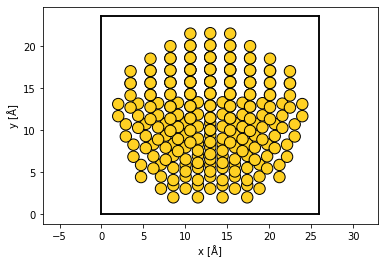

In [3]:
show_atoms(atoms, plane='xy')

In [4]:
potential = Potential(atoms=FrozenPhonons(atoms, sigmas=.0, num_configs=1),
                      projection='infinite',
                      parametrization='kirkland')

S = SMatrix(semiangle_cutoff=15, energy=100e3, gpts=128, interpolation=1, device='cpu')

detector = PixelatedDetector()

scan = GridScan((0, 0), np.diag(atoms.cell)[:2], sampling=S.ctf.nyquist_sampling * .9)

measurement = S.scan(scan, detector, potential)

Potential:   0%|          | 0/38 [00:00<?, ?it/s]

Multislice:   0%|          | 0/315 [00:00<?, ?it/s]

Scan:   0%|          | 0/6545 [00:00<?, ?it/s]

In [5]:
canvas1 = Canvas()
canvas2 = Canvas()

probe_artist = MeasurementArtist2d()
diffraction_artist = MeasurementArtist2d()

canvas1.artists = {'artist': probe_artist}
canvas2.artists = {'artist': diffraction_artist}

position_tool = SelectPixelTool(image_artist=probe_artist.image_artist, marker=True)
box_select_pixel = BoxSelectPixelTool(image_artist=diffraction_artist.image_artist)

box_select_pixel.selected_x = [20, 50]
box_select_pixel.selected_y = [20, 50]

canvas1.tools = {'Pixel select': position_tool, 'Zoom': BoxZoomTool(), 'Pan': PanZoomTool(), }
canvas2.tools = {'Box select': box_select_pixel, 'Zoom': BoxZoomTool(), 'Pan': PanZoomTool()}


def update_image(*args):
    slice_x = slice(*box_select_pixel.selected_x)
    slice_y = slice(*box_select_pixel.selected_y)

    for slic in (slice_x, slice_y):
        if slic.start == slic.stop:
            return

    probe_artist.measurement = measurement[:, :, slice_x, slice_y].sum((-1, -2))


def update(*args):
    diffraction_artist.measurement = measurement[position_tool.index_x, position_tool.index_y]


position_tool.observe(update)
box_select_pixel.observe(update_image)

update_image()
update()

canvas1.adjust_limits_to_artists()
canvas1.adjust_labels_to_artists()
canvas2.adjust_limits_to_artists()
canvas2.adjust_labels_to_artists()

toolbar1 = canvas1.toolbar

autoadjust_colorscale_button = widgets.ToggleButton(description='Autoadjust colorscale', value=True)
link((autoadjust_colorscale_button, 'value'), (probe_artist.image_artist, 'autoadjust_colorscale'))
autoadjust_colorscale_button.observe(probe_artist.image_artist._observe_image, 'value')

cbar1 = probe_artist.image_artist.colorbar
cbar1.layout.width = '450px'
cbar1.label = 'Intensity [arb. unit]'

cbar2 = diffraction_artist.image_artist.colorbar
cbar2.layout.width = '450px'
cbar2.label = 'Intensity [arb. unit]'

spacing = widgets.HBox([])
spacing.layout.width = '60px'

box = widgets.HBox([widgets.VBox([cbar1, canvas1.figure, toolbar1, autoadjust_colorscale_button]),
                    spacing,
                    widgets.VBox(
                        [cbar2, canvas2.figure, canvas2.toolbar, diffraction_artist.image_artist.color_scheme_picker,
                         diffraction_artist.image_artist.power_scale_slider])])

box